C:\Users\cello\AppData\Local\Temp\ipykernel_49804\446384126.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


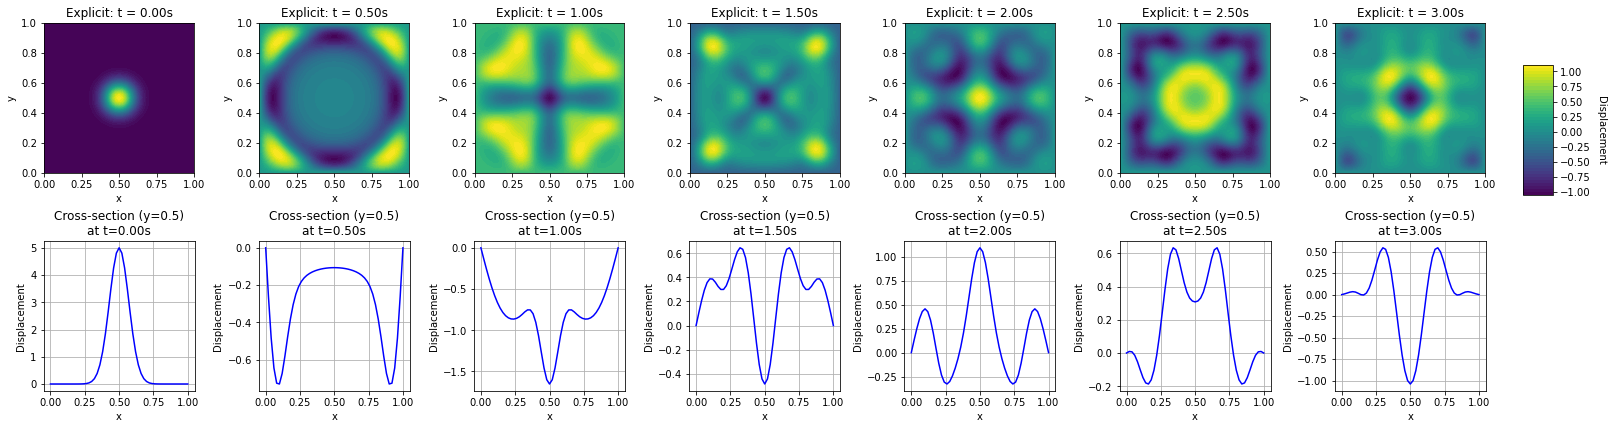

MovieWriter ffmpeg unavailable; using Pillow instead.


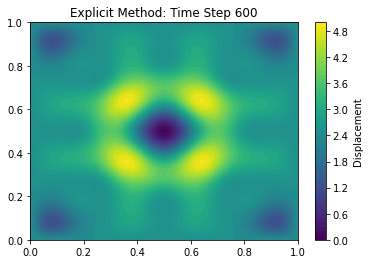

C:\Users\cello\AppData\Local\Temp\ipykernel_49804\446384126.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


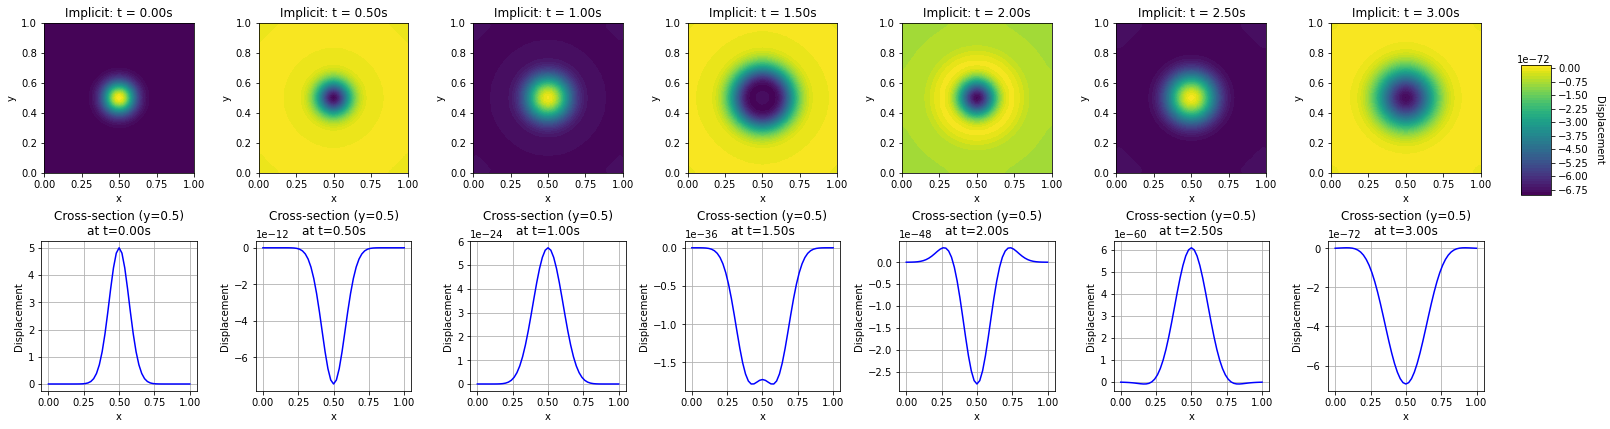

MovieWriter ffmpeg unavailable; using Pillow instead.


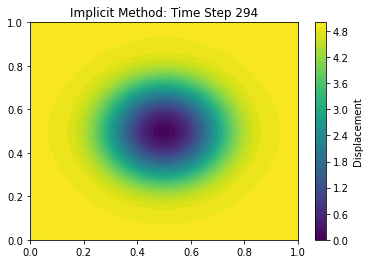

c:\Users\cello\anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


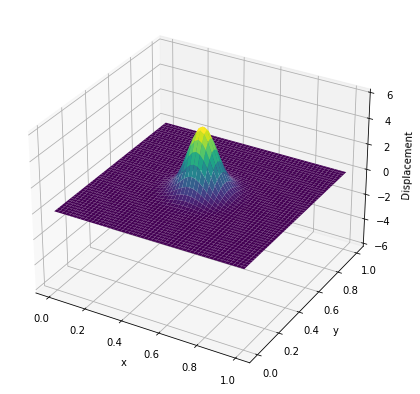

CW done: I deserve a good mark


In [2]:
# In this section I am importing all the libraries I will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim  # Using alias 'anim' for animation functions
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# In this section I am setting the domain of solution and the discretised grid
L = 1.0          # Domain length (both x and y directions)
T = 3.0          # Total simulation time
c = 1.0          # Wave speed (constant)

nx, ny = 51, 51          # Number of grid points in x and y directions
dx = L / (nx - 1)        # Grid spacing in x-direction (dy is assumed equal)
dy = dx                  # Grid spacing in y-direction

dt_exp = 0.005          # Time step for explicit finite difference method (CFL condition applies)
dt_impl = 0.01          # Time step for implicit method
CFL = c * dt_exp / dx   # Courant number (stability requirement)

nt_exp = int(T / dt_exp) + 1  # Total explicit time steps
nt_impl = int(T / dt_impl) + 1  # Total implicit time steps

# Create spatial grid using np.linspace and np.meshgrid
# 'ij' indexing ensures X[i,j] corresponds to x_i and Y[i,j] to y_j
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# In this section I am defining arrays I would need (if needed)
# (Arrays for the numerical solution will be allocated below in each method)

# In this section I am setting the boundary conditions/initial values
# Define the initial displacement as a Gaussian pulse (drumhead)
u0 = 5 * np.exp(-100 * ((X - 0.5)**2 + (Y - 0.5)**2))
# Enforce Dirichlet boundary conditions (fixed edges: u = 0)
u0[0, :], u0[-1, :], u0[:, 0], u0[:, -1] = 0, 0, 0, 0

# In this section I am implementing the numerical method

## Explicit Finite Difference Method
u_exp = np.zeros((nt_exp, nx, ny))  # Allocate solution array for explicit method
u_exp[0] = u0.copy()  # Set initial condition at t = 0

# First time step (using a Taylor expansion)
laplacian_u0_exp = np.zeros_like(u0)
laplacian_u0_exp[1:-1, 1:-1] = (
    u_exp[0, 2:, 1:-1] + u_exp[0, :-2, 1:-1] +
    u_exp[0, 1:-1, 2:] + u_exp[0, 1:-1, :-2] -
    4 * u_exp[0, 1:-1, 1:-1]
) / (dx**2)
u_exp[1, 1:-1, 1:-1] = u0[1:-1, 1:-1] + 0.5 * (c**2 * dt_exp**2) * laplacian_u0_exp[1:-1, 1:-1]

# Time-stepping loop for the explicit method
for n in range(1, nt_exp - 1):
    laplacian_un = np.zeros_like(u_exp[n])
    laplacian_un[1:-1, 1:-1] = (
        u_exp[n, 2:, 1:-1] + u_exp[n, :-2, 1:-1] +
        u_exp[n, 1:-1, 2:] + u_exp[n, 1:-1, :-2] -
        4 * u_exp[n, 1:-1, 1:-1]
    ) / (dx**2)
    u_exp[n+1, 1:-1, 1:-1] = (
        2 * u_exp[n, 1:-1, 1:-1] - u_exp[n-1, 1:-1, 1:-1] +
        (c**2 * dt_exp**2) * laplacian_un[1:-1, 1:-1]
    )

## Implicit Method
alpha_impl = c**2 * dt_impl**2 / dx**2  # Coefficient in the implicit scheme

u_impl = np.zeros((nt_impl, nx, ny))  # Allocate solution array for implicit method
u_impl[0] = u0.copy()

# Compute the first implicit time step using a Taylor expansion (similar to explicit)
laplacian_u0_impl = np.zeros_like(u0)
laplacian_u0_impl[1:-1, 1:-1] = (
    u_impl[0, 2:, 1:-1] + u_impl[0, :-2, 1:-1] +
    u_impl[0, 1:-1, 2:] + u_impl[0, 1:-1, :-2] -
    4 * u_impl[0, 1:-1, 1:-1]
) / (dx**2)
u_impl[1, 1:-1, 1:-1] = u0[1:-1, 1:-1] + 0.5 * (c**2 * dt_impl**2) * laplacian_u0_impl[1:-1, 1:-1]
# Reapply Dirichlet boundary conditions
u_impl[1, 0, :], u_impl[1, -1, :], u_impl[1, :, 0], u_impl[1, :, -1] = 0, 0, 0, 0

# Construct the system matrix for the interior nodes (implicit method)
nx_i = nx - 2  # Interior points in x
ny_i = ny - 2  # Interior points in y

main_diag = (1 + 4 * alpha_impl) * np.ones(nx_i)
off_diag = -alpha_impl * np.ones(nx_i - 1)
Tx = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc')
Ty = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc')

I_nx = sp.eye(nx_i, format='csc')
I_ny = sp.eye(ny_i, format='csc')
A_matrix = sp.kron(I_ny, Tx) + sp.kron(Ty, I_nx)

# Time-stepping loop for the implicit method
for n in range(1, nt_impl - 1):
    b = 2 * u_impl[n, 1:-1, 1:-1] - u_impl[n-1, 1:-1, 1:-1]
    b = b.flatten()  # Flatten the interior grid into a vector
    u_int_next = spla.spsolve(A_matrix, b)
    u_impl[n+1, 1:-1, 1:-1] = u_int_next.reshape((nx_i, ny_i))

## Crank-Nicolson Method
alpha_cn = c**2 * dt_impl**2 / (2 * dx**2)  # Crank-Nicolson coefficient

u_cn = np.zeros((nt_impl, nx, ny))
vu_cn = np.zeros((nt_impl, nx, ny))
vu_cn[0] = u0.copy()
vu_cn[1, 1:-1, 1:-1] = u0[1:-1, 1:-1] + 0.5 * (c**2 * dt_impl**2) * laplacian_u0_impl[1:-1, 1:-1]
vu_cn[1, 0, :], vu_cn[1, -1, :], vu_cn[1, :, 0], vu_cn[1, :, -1] = 0, 0, 0, 0

main_diag_cn = (1 + 2 * alpha_cn) * np.ones(nx_i)
off_diag_cn = (-alpha_cn) * np.ones(nx_i - 1)
Tx_cn = sp.diags([off_diag_cn, main_diag_cn, off_diag_cn], offsets=[-1, 0, 1], format='csc')
Ty_cn = sp.diags([off_diag_cn, main_diag_cn, off_diag_cn], offsets=[-1, 0, 1], format='csc')
A_cn = sp.kron(I_ny, Tx_cn) + sp.kron(Ty_cn, I_nx)

for n in range(1, nt_impl - 1):
    b_cn = (1 - 2 * alpha_cn) * vu_cn[n, 1:-1, 1:-1] + alpha_cn * (
           vu_cn[n, 2:, 1:-1] + vu_cn[n, :-2, 1:-1] +
           vu_cn[n, 1:-1, 2:] + vu_cn[n, 1:-1, :-2])
    b_cn = b_cn.flatten()
    u_int_next_cn = spla.spsolve(A_cn, b_cn)
    vu_cn[n+1, 1:-1, 1:-1] = u_int_next_cn.reshape((nx_i, ny_i))
    vu_cn[n+1, 0, :], vu_cn[n+1, -1, :], vu_cn[n+1, :, 0], vu_cn[n+1, :, -1] = 0, 0, 0, 0

# In this section I am showing the results

## Static Visualization for Explicit and Implicit Methods
time_points = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0]

# Explicit Method Static Plots
fig, axs = plt.subplots(2, len(time_points), figsize=(3 * len(time_points), 6))
for i, t in enumerate(time_points):
    idx_exp = int(t / dt_exp)
    cp = axs[0, i].contourf(X, Y, u_exp[idx_exp, :, :], levels=50, cmap='viridis')
    axs[0, i].set_title(f'Explicit: t = {t:.2f}s')
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('y')
    axs[0, i].set_aspect('equal', 'box')
    axs[0, i].grid(False)
    axs[1, i].plot(x, u_exp[idx_exp, :, ny // 2], color='b')
    axs[1, i].set_title(f'Cross-section (y=0.5)\nat t={t:.2f}s')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('Displacement')
    axs[1, i].set_aspect('auto')
    axs[1, i].grid(True)
plt.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([1.01, 0.55, 0.02, 0.3])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label('Displacement', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

# Animated Plot for Explicit Method
fig_exp, ax_exp = plt.subplots()
u_profile_exp = ax_exp.contourf(X, Y, u_exp[0, :, :], levels=50, vmin=0, vmax=5)
cbar_exp = plt.colorbar(u_profile_exp, ax=ax_exp)
cbar_exp.set_label("Displacement")

def update_exp(frame):
    ax_exp.clear()
    u_profile_exp = ax_exp.contourf(X, Y, u_exp[frame, :, :], levels=50)
    ax_exp.set_title(f"Explicit Method: Time Step {frame}")
    return u_profile_exp

ani_exp = anim.FuncAnimation(fig_exp, update_exp, frames=range(0, nt_exp, 5), interval=50)
ani_exp.save("explicit_animation.gif")
plt.show()

# Implicit Method Static Plots
fig, axs = plt.subplots(2, len(time_points), figsize=(3 * len(time_points), 6))
for i, t in enumerate(time_points):
    idx_impl = int(t / dt_impl)
    cp = axs[0, i].contourf(X, Y, u_impl[idx_impl, :, :], levels=50, cmap='viridis')
    axs[0, i].set_title(f'Implicit: t = {t:.2f}s')
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('y')
    axs[0, i].set_aspect('equal', 'box')
    axs[0, i].grid(False)
    axs[1, i].plot(x, u_impl[idx_impl, :, ny // 2], color='b')
    axs[1, i].set_title(f'Cross-section (y=0.5)\nat t={t:.2f}s')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('Displacement')
    axs[1, i].set_aspect('auto')
    axs[1, i].grid(True)
plt.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([1.01, 0.55, 0.02, 0.3])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label('Displacement', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

# Animated Plot for Implicit Method
fig_impl, ax_impl = plt.subplots()
u_profile_impl = ax_impl.contourf(X, Y, u_impl[0, :, :], levels=50, vmin=0, vmax=5)
cbar_impl = plt.colorbar(u_profile_impl, ax=ax_impl)
cbar_impl.set_label("Displacement")

def update_impl(frame):
    ax_impl.clear()
    u_profile_impl = ax_impl.contourf(X, Y, u_impl[frame, :, :], levels=50)
    ax_impl.set_title(f"Implicit Method: Time Step {frame}")
    return u_profile_impl

ani_impl = anim.FuncAnimation(fig_impl, update_impl, frames=range(0, nt_impl, 7), interval=50)
ani_impl.save("implicit_animation.gif")
plt.show()

# 3D Animated Surface Plot for Implicit Method
fig_3d = plt.figure(figsize=(10, 7))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.set_xlabel('x')
ax_3d.set_ylabel('y')
ax_3d.set_zlabel('Displacement')
ax_3d.set_zlim(-6, 6)
surf = [ax_3d.plot_surface(X, Y, u_impl[0, :, :], cmap='viridis', rstride=1, cstride=1)]

def update_surface(frame):
    ax_3d.collections.clear()
    surf[0] = ax_3d.plot_surface(X, Y, u_impl[frame, :, :], cmap='viridis', rstride=1, cstride=1)
    ax_3d.set_title(f"Implicit Method: t = {frame * dt_impl:.2f} s")
    return surf[0],

ani_3d = anim.FuncAnimation(fig_3d, update_surface, frames=nt_impl, interval=50)
plt.show()

# In this section I am celebrating
print('CW done: I deserve a good mark')
